### Note: this notebook was originally hosted on Google Colab.

In [ ]:
# Check that it is running on GPU.

!nvidia-smi

Wed May 24 15:44:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install the required libraries.

!pip install transformers
!pip install datasets
!pip install jiwer
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator
from datasets import load_metric

from google.colab import files

In [ ]:
# Class that encodes data as text.

class IAMDataset(Dataset):


    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
# Function that creates dataframes containing information for the train, validation & test sets.

def create_df(tvt=None):

    filenames = os.listdir(f'./data/{tvt}')
    labels = [(' '.join(i.split('_')[2:]).split('.')[0]) for i in filenames]

    df = pd.DataFrame()

    df['file_name'] = filenames
    df['text'] = labels

    return df

In [ ]:
# Class that generates predictions for the untrained TrOCR model.

class UntrainedPreds():


    def __init__(
        self,
        df=None,
        tvt=None,
        target_width=384,
        target_height=384
        ):

        self.df = df
        self.tvt = tvt
        self.directory_path = f'./data/{self.tvt}/'
        self.target_width = target_width
        self.target_height = target_height

        self.generate_preds()


    def process(self, image=None):

        self.image = image
        self.target_size = (self.target_width, self.target_height)
        self.width, self.height = self.image.size

        # Calculate the aspect ratio
        self.aspect_ratio = self.width / self.height

        # Determine the new size while maintaining the aspect ratio
        if self.aspect_ratio > 1:

            self.new_width = self.target_width
            self.new_height = int(self.target_height / self.aspect_ratio)

        else:

            self.new_width = int(self.target_width * self.aspect_ratio)
            self.new_height = self.target_height

        # Resize the image while maintaining the aspect ratio
        self.resized_image = self.image.resize((self.new_width, self.new_height))

        # Create a white background image with the target size
        self.padded_image = Image.new("RGB", self.target_size, (255, 255, 255))

        # Calculate the offset for pasting the resized image onto the padded image
        self.offset = ((self.target_width - self.new_width) // 2, (self.target_height - self.new_height) // 2)

        # Paste the resized image onto the padded image
        self.padded_image.paste(self.resized_image, self.offset)

        return self.padded_image


    def generate_preds(self):

        self.preds = []

        # Iterate over the images in the directory
        for filename in os.listdir(self.directory_path):

            # Load and resize the input image
            self.input_image = Image.open(os.path.join(self.directory_path, filename)).convert("RGB")
            self.img = self.process(image=self.input_image)

            # Prepare the input image
            self.image_tensor = ToTensor()(self.img).unsqueeze(0).to(torch.device('cuda'))

            # Generate predictions
            self.outputs = model.generate(pixel_values=self.image_tensor)

            # Access the generated sequences using outputs[0]
            self.predicted_ids = self.outputs[0]

            # Decode the predicted ids to text
            self.predicted_text = ''.join(processor.tokenizer.batch_decode(self.predicted_ids, skip_special_tokens=True))

            self.preds.append(self.predicted_text)

        self.df['untrained_preds'] = self.preds

        self.df['exact_match_untrained'] = self.df.apply(lambda x: True if x.text==x.untrained_preds else False, axis=1)

In [ ]:
# Function that computes either WER or CER for the predictions.

def compute_metrics(pred, metric='cer'):

    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    if metric == 'cer':

      cer_metric = load_metric("cer")
      cer = cer_metric.compute(predictions=pred_str, references=label_str)
      return {"cer": cer}

    elif metric == 'wer':

      wer_metric = load_metric("wer")
      wer = wer_metric.compute(predictions=pred_str, references=label_str)
      return {"wer": wer}

In [ ]:
# Function that gets predictions and adds on the resulting information to the dataframes.

def get_preds(df=None, dataset=None):

  predictions = trainer.predict(dataset)
  predicted_ids = predictions.predictions
  predicted_labels = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

  df['preds'] = predicted_labels

  df['exact_match'] = df.apply(lambda x: True if x.text==x.preds else False, axis=1)

In [ ]:
# Function that displays the data & their predictions.

def visualise(df=None, dataset=None, num=None):

  image = Image.open(dataset.root_dir + df['file_name'][num]).convert("RGB")

  display(df.iloc[num, 1:])
  display(image)

In [ ]:
# Load the processor.

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
# Load the pretrained model.

model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move the model to the GPU.

model = model.to(torch.device('cuda'))

In [ ]:
# Create a list of strings that will often be used later.

tvt_all = ['train', 'valid', 'test']

In [ ]:
# Using the create_df() function, create dataframes for the train, validation & test datasets.

df_train = create_df('train')
df_valid = create_df('valid')
df_test = create_df('test')

In [ ]:
# Create a list containing the dataframes.

df_all = [df_train, df_valid, df_test]

In [ ]:
# Generate predictions from the untrained model for all the datasets.

for df, tvt in zip(df_all, tvt_all):
    UntrainedPreds(df=df, tvt=tvt)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control

In [ ]:
# Using the IAMDataset() function, format the train dataset to be compatible with the TrOCR model.

train_dataset = IAMDataset(
    root_dir='./data/train/',
    df=df_train,
    processor=processor
)

In [ ]:
# Using the IAMDataset() function, format the validation dataset to be compatible with the TrOCR model.

valid_dataset = IAMDataset(
    root_dir='./data/valid/',
    df=df_valid,
    processor=processor
)

In [ ]:
# Using the IAMDataset() function, format the test dataset to be compatible with the TrOCR model.

test_dataset = IAMDataset(
    root_dir='./data/test/',
    df=df_test,
    processor=processor
)

In [ ]:
# Create a list containing the formatted datasets.

datasets = [train_dataset, valid_dataset, test_dataset]

In [ ]:
# Set special tokens used for creating the decoder_input_ids from the labels.

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

In [ ]:
# Make sure vocab size is set correctly.

model.config.vocab_size = model.config.decoder.vocab_size

In [ ]:
# Set beam search parameters.

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
# Set parameters to be used in training the model on the custom dataset.

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [ ]:
# Instantiate trainer.

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
# Train the model.

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,0.320100,0.515572,0.074705
400,0.056200,0.290272,0.028077
600,0.044700,0.220601,0.021810


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
<ipython-input-7-2975d64c960a>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


TrainOutput(global_step=663, training_loss=0.4429090308140666, metrics={'train_runtime': 1011.1788, 'train_samples_per_second': 5.236, 'train_steps_per_second': 0.656, 'total_flos': 3.9621700863236506e+18, 'train_loss': 0.4429090308140666, 'epoch': 3.0})

In [ ]:
# Obtain predictions for all datasets.

for df, dataset in zip(df_all, datasets):
  get_preds(df=df, dataset=dataset)

In [ ]:
# Update the dataframes with the accuracy of the predictions.

for df in df_all:
  df['exact_match'] = df.apply(lambda x: True if x.text==x.preds else False, axis=1)

train


text                      division
untrained_preds          division.
exact_match_untrained        False
preds                     division
exact_match                   True
Name: 1253, dtype: object

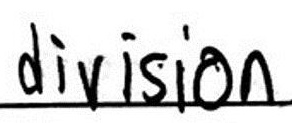

train


text                     Spei es
untrained_preds          Species
exact_match_untrained      False
preds                    Spei es
exact_match                 True
Name: 1524, dtype: object

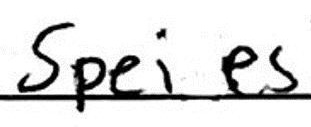

train


text                      safety pins
untrained_preds          safety pine.
exact_match_untrained           False
preds                     safety pins
exact_match                      True
Name: 119, dtype: object

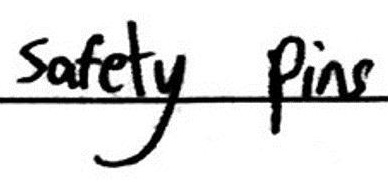

train


text                      beeline
untrained_preds          beeline.
exact_match_untrained       False
preds                     beeline
exact_match                  True
Name: 213, dtype: object

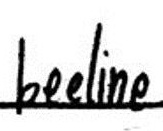

train


text                      relised
untrained_preds          relished
exact_match_untrained       False
preds                     relised
exact_match                  True
Name: 1408, dtype: object

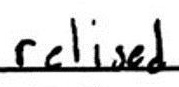

valid


text                      recipe
untrained_preds          recipe.
exact_match_untrained      False
preds                     recipe
exact_match                 True
Name: 325, dtype: object

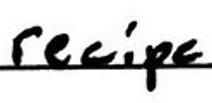

valid


text                     rescued
untrained_preds          rescued
exact_match_untrained       True
preds                    rescued
exact_match                 True
Name: 353, dtype: object

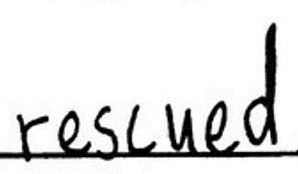

valid


text                      worthwhile
untrained_preds          worthwhite.
exact_match_untrained          False
preds                     worthwhile
exact_match                     True
Name: 150, dtype: object

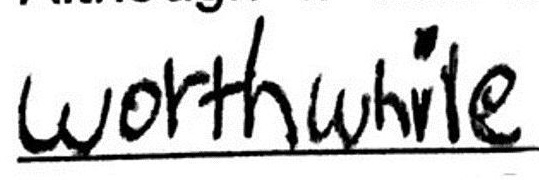

valid


text                     disappear
untrained_preds          disappear
exact_match_untrained         True
preds                    disappear
exact_match                   True
Name: 145, dtype: object

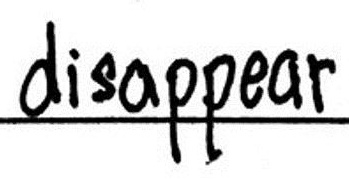

valid


text                         -
untrained_preds          jurji
exact_match_untrained    False
preds                        -
exact_match               True
Name: 367, dtype: object

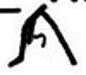

test


text                      threat
untrained_preds          threat.
exact_match_untrained      False
preds                     threat
exact_match                 True
Name: 221, dtype: object

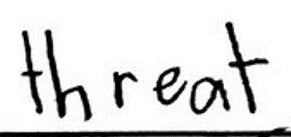

test


text                     passengers
untrained_preds          passengers
exact_match_untrained          True
preds                    passengers
exact_match                    True
Name: 102, dtype: object

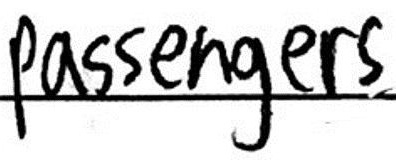

test


text                      competition
untrained_preds          competition.
exact_match_untrained           False
preds                     competition
exact_match                      True
Name: 101, dtype: object

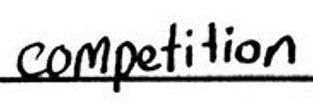

test


text                     disappeared
untrained_preds          disappeared
exact_match_untrained           True
preds                    disappeared
exact_match                     True
Name: 243, dtype: object

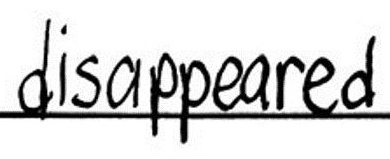

test


text                       bumblebees
untrained_preds          bumble bees.
exact_match_untrained           False
preds                      bumblebees
exact_match                      True
Name: 119, dtype: object

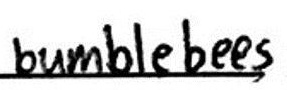

In [ ]:
# Randomly generate 5 data points & their predictions.

for df, dataset, tvt in zip(df_all, datasets, tvt_all):

  for i in np.random.default_rng().integers(df.shape[0], size=5):

    print(tvt)
    visualise(df=df, dataset=dataset, num=i)

In [ ]:
# Create a dataframe to store the WER for the various sets of predictions.

df_wer = pd.DataFrame()

df_wer['tvt'] = [i for i in tvt_all for _ in range(2)]
df_wer['type'] = [i for _ in range(3) for i in ['untrained', 'trained']]
df_wer['wer'] = [df[f'exact_match{col}'].value_counts(normalize=True)[1] for df in df_all for col in ['_untrained', '']]

In [ ]:
# Download the files.

for df, filename in zip(df_all+[df_wer], tvt_all+['wer']):

    df.to_csv(f'pred_{filename}.csv')
    files.download(f'pred_{filename}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# encoding = train_dataset[0]
# for k,v in encoding.items():
#     print(k, v.shape)

In [ ]:
# Image.open(train_dataset.root_dir + df_train['file_name'][0]).convert("RGB")

In [ ]:
# labels = encoding['labels']
# labels[labels == -100] = processor.tokenizer.pad_token_id
# label_str = processor.decode(labels, skip_special_tokens=True)
# print(label_str)